# Allenamento rete ResNet50 per Pose Estimaiton

Questo notebook permette di:
1. **Import e Setup**
2. **Carica dataset LineMOD** con split ufficiale train/test
3. **Inizializza PoseEstimator** (ResNet-50 backbone + regression head)
4. **Training**
5. **Valutazione con ADD metric** sul test set


Esegui sempre sezione 1 e 2 per configurare l'ambiente. Poi scegli:
- **Training completo**
- **Test modello già trainato -> Punto 5**

## 1. Import e Setup

In [ ]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import yaml
import pandas as pd
import random


# Importa il config per usare path e file in altre cartelle
sys.path.insert(0, str(Path.cwd().parent))  # Aggiungi parent al path
from config import Config
from utils.transforms import quaternion_to_rotation_matrix_batch
from dataset.custom_dataset import create_pose_dataloaders
from models.pose_estimator import PoseEstimator
from utils.losses import PoseLoss
from utils.metrics import load_all_models, load_models_info, compute_add_batch, compute_add_batch_gpu

# Usa PROJECT_ROOT dal config
project_root = Config.PROJECT_ROOT
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))


# Configura matplotlib per notebook
%matplotlib inline

print(f"✅ Setup completato")
print(f"📂 Project root: {project_root}")
print(f"🎯 Dataset: LineMOD")
print(f"🖥️  Device: {Config.DEVICE}")
print(f"📊 Image size: {Config.POSE_IMAGE_SIZE}x{Config.POSE_IMAGE_SIZE}")
print(f"🔢 Batch size: {Config.POSE_BATCH_SIZE}")
print(f"🚀 GPU-accelerated ADD metric: {'✅ Enabled' if Config.DEVICE == 'cuda' else '❌ CPU only'}")

✅ Setup completato
📂 Project root: C:\Users\Alessandro\Desktop\polito-aml-6D-pose-estimation
🎯 Dataset: LineMOD
🖥️  Device: cuda
📊 Image size: 224x224
🔢 Batch size: 64


## 2. Carica dataset LineMOD

In [2]:
# Carica dataset con split ufficiale train/test
print("📦 Caricamento PoseDataset con split ufficiale...\n")

train_loader, test_loader = create_pose_dataloaders(
    dataset_root=Config.LINEMOD_ROOT,
    batch_size=Config.POSE_BATCH_SIZE,
    crop_margin=Config.POSE_CROP_MARGIN,
    output_size=Config.POSE_IMAGE_SIZE,
    num_workers=Config.NUM_WORKERS_POSE  # Adaptive: 0 on MPS, optimal on CUDA/CPU
)

print(f"✅ Dataset caricato:")
print(f"   Train batches: {len(train_loader)} (batch_size={Config.POSE_BATCH_SIZE})")
print(f"   Test batches: {len(test_loader)}")
print(f"   Train samples: ~{len(train_loader) * Config.POSE_BATCH_SIZE}")
print(f"   Test samples: ~{len(test_loader) * Config.POSE_BATCH_SIZE}")
print(f"   Crop margin: {Config.POSE_CROP_MARGIN * 100:.0f}%")
print(f"   Output size: {Config.POSE_IMAGE_SIZE}x{Config.POSE_IMAGE_SIZE}")
print(f"   Workers: {Config.NUM_WORKERS_POSE} (adaptive per {Config.DEVICE})")

📦 Caricamento PoseDataset con split ufficiale...

🔄 Preloading metadata for 13 folders...
✅ PoseDataset initialized: 3759 train samples
🚀 Cached 13 gt.yml and 13 info.yml files
🔄 Preloading metadata for 13 folders...
✅ PoseDataset initialized: 21218 test samples
🚀 Cached 13 gt.yml and 13 info.yml files

📊 Pose DataLoaders created:
   Training samples: 3759
   Training batches: 59
   Test samples: 21218
   Test batches: 332
✅ Dataset caricato:
   Train batches: 59 (batch_size=64)
   Test batches: 332
   Train samples: ~3776
   Test samples: ~21248
   Crop margin: 15%
   Output size: 224x224
   Workers: 8 (adaptive per cuda)


### Visualizza immagini training set con info su traslazione e rotazioni


🖼️  Visualizzazione sample del training set



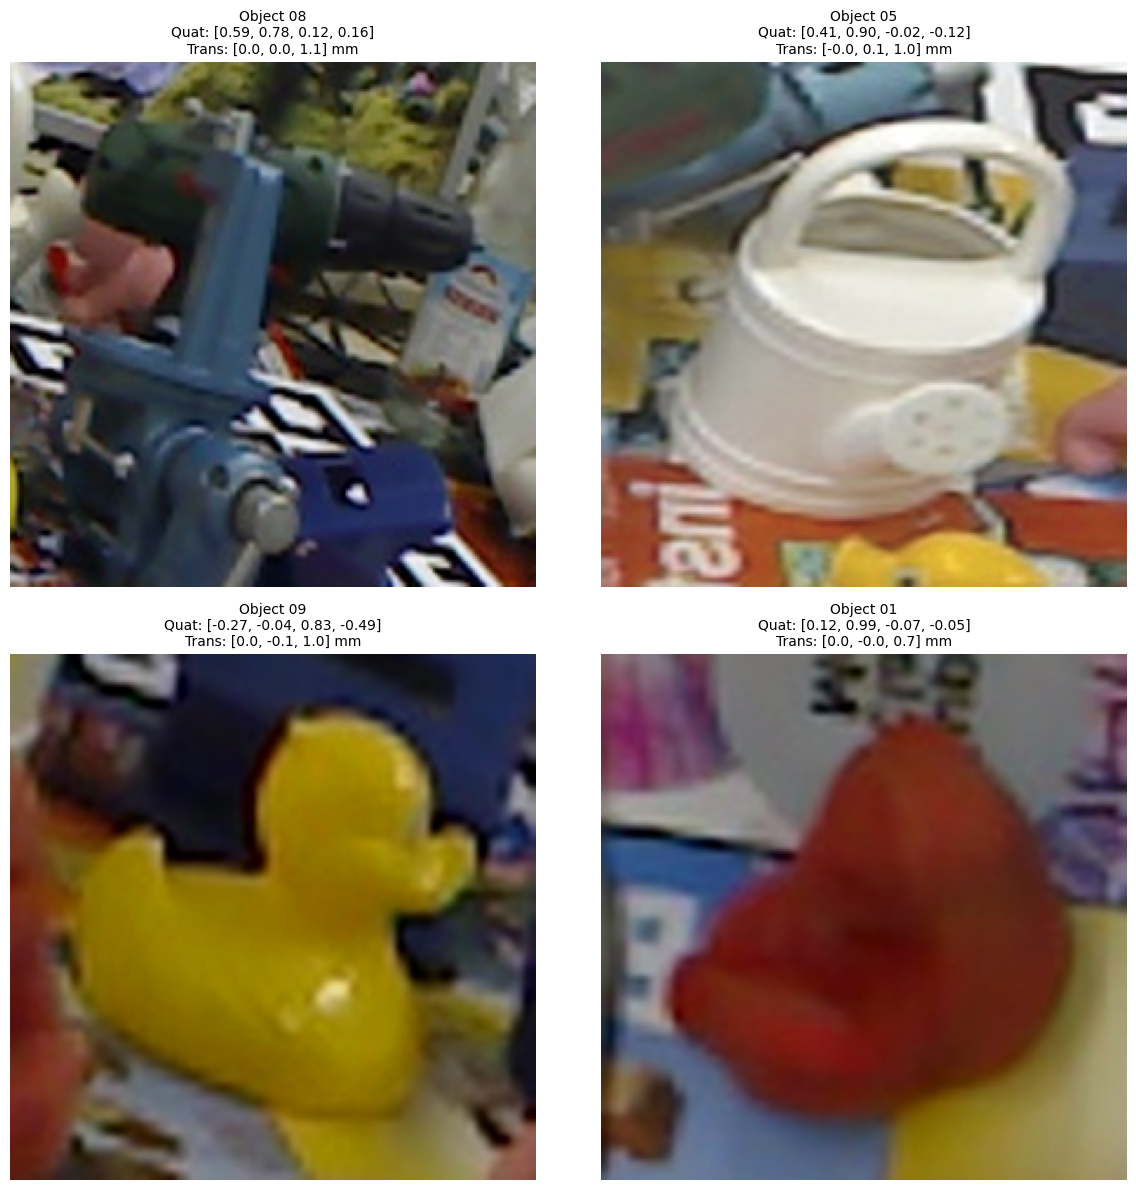

✅ Visualizzazione completata!
   Crop centrato sul bbox con 15% margin
   Quaternion normalizzato (||q|| = 1)
   Translation in millimetri (mm)


In [3]:
# Visualizza alcuni sample del dataset
print("\n🖼️  Visualizzazione sample del training set\n")

# Prendi un batch
batch = next(iter(train_loader))
images = batch['rgb_crop']  # [B, 3, 224, 224]
quaternions = batch['quaternion']  # [B, 4]
translations = batch['translation']  # [B, 3]
obj_ids = batch['obj_id']  # [B]

# Visualizza 4 sample
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for i in range(min(4, len(images))):
    # Denormalizza immagine (ImageNet normalization)
    img = images[i].permute(1, 2, 0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img * std + mean
    img = np.clip(img, 0, 1)
    
    # Ground truth
    quat = quaternions[i].cpu().numpy()
    trans = translations[i].cpu().numpy()
    obj_id = obj_ids[i].item()
    
    axes[i].imshow(img)
    axes[i].set_title(
        f"Object {obj_id:02d}\n"
        f"Quat: [{quat[0]:.2f}, {quat[1]:.2f}, {quat[2]:.2f}, {quat[3]:.2f}]\n"
        f"Trans: [{trans[0]:.1f}, {trans[1]:.1f}, {trans[2]:.1f}] mm",
        fontsize=10
    )
    axes[i].axis('off')

plt.tight_layout()
plt.show()

print(f"✅ Visualizzazione completata!")
print(f"   Crop centrato sul bbox con {Config.POSE_CROP_MARGIN * 100:.0f}% margin")
print(f"   Quaternion normalizzato (||q|| = 1)")
print(f"   Translation in millimetri (mm)")

## 3. Inizializza Modello PoseEstimator

ResNet-50 backbone (pretrained ImageNet) + regression head (Linear 2048→1024→512→7).
Output: 4D quaternion [qw, qx, qy, qz] + 3D translation [tx, ty, tz]

In [4]:
# Inizializza PoseEstimator con backbone SBLOCCATO (Fase 1 ottimizzazione)
print("🤖 Inizializzazione PoseEstimator...\n")

model = PoseEstimator(
    pretrained=True,
    dropout=Config.POSE_DROPOUT,
    freeze_backbone=False  # ✅ SBLOCCATO per fine-tuning completo
).to(Config.DEVICE)

print(f"✅ Modello inizializzato:")
print(f"   Backbone: ResNet-50 (pretrained ImageNet)")
print(f"   Dropout: {Config.POSE_DROPOUT}")
print(f"   Output: 4D quaternion + 3D translation")

# Conta parametri
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Parametri del modello:")
print(f"   Parametri totali: {total_params:,}")
print(f"   Parametri trainable: {trainable_params:,}")
print(f"   Percentuale trainable: {100 * trainable_params / total_params:.1f}%")

print(f"\n💡 Modalità: Backbone SBLOCCATO (Fase 1)")
print(f"   Tutti i parametri trainable (~25M)")
print(f"   Fine-tuning completo ResNet-50 + regression head")
print(f"   Training più lento ma risultati migliori")

🤖 Inizializzazione PoseEstimator...



c:\Users\Alessandro\Desktop\polito-aml-6D-pose-estimation\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alessandro\Desktop\polito-aml-6D-pose-estimation\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ PoseEstimator initialized
   Backbone: resnet50 (pretrained=True, frozen=False)
   Feature dim: 2048
   Output: 7 values (4 quaternion + 3 translation)
   Dropout: 0.5
✅ Modello inizializzato:
   Backbone: ResNet-50 (pretrained ImageNet)
   Dropout: 0.5
   Output: 4D quaternion + 3D translation

📊 Parametri del modello:
   Parametri totali: 26,137,671
   Parametri trainable: 26,137,671
   Percentuale trainable: 100.0%

💡 Modalità: Backbone SBLOCCATO (Fase 1)
   Tutti i parametri trainable (~25M)
   Fine-tuning completo ResNet-50 + regression head
   Training più lento ma risultati migliori


## 4. Training

Training rapido per testare il pipeline. Per risultati migliori, usa 50 epoche con backbone unfrozen.

In [5]:
# ⚡ FASE 1: TRAINING OTTIMIZZATO
# - Backbone sbloccato
# - Learning rate differenziato
# - Warmup + ReduceLROnPlateau

EPOCHS = Config.POSE_EPOCHS  # ✅ Ridotto: backbone unfrozen converge più velocemente
WARMUP_EPOCHS = 5  # ✅ Warmup graduale per stabilizzare training
EXPERIMENT_NAME = "pose_stable_train100"

# Learning rates differenziati
LR_BACKBONE = 5e-6  # da 1e-5 a 5e-6 (più conservativo)
LR_HEAD = 1e-4      # Standard per regression head

# Gradient Accumulation
ACCUMULATION_STEPS = Config.ACCUMULATION_STEPS
EFFECTIVE_BATCH_SIZE = Config.POSE_BATCH_SIZE * ACCUMULATION_STEPS

print(f"⚡ FASE 1 - Training Ottimizzato:")
print(f"   Esperimento: {EXPERIMENT_NAME}")
print(f"   Epoche: {EPOCHS} (+ {WARMUP_EPOCHS} warmup)")
print(f"   Batches per epoca: {len(train_loader)}")
print(f"   🚀 LR Backbone: {LR_BACKBONE:.2e} (fine-tuning delicato)")
print(f"   🚀 LR Head: {LR_HEAD:.2e} (standard)")
print(f"   🚀 Batch size: {Config.POSE_BATCH_SIZE}")
print(f"   🚀 Accumulation steps: {ACCUMULATION_STEPS}")
print(f"   🚀 Effective batch size: {EFFECTIVE_BATCH_SIZE}")
print(f"   Lambda translation: {Config.LAMBDA_TRANS}")
print(f"   Lambda rotation: {Config.LAMBDA_ROT}")
print(f"   Device: {Config.DEVICE}")

# AMP per CUDA
use_amp = Config.DEVICE == 'cuda' and hasattr(torch.cuda, 'amp')
if use_amp:
    print(f"   🚀 AMP enabled (FP16 training)")
    scaler = torch.amp.GradScaler()
else:
    print(f"   ⚠️  AMP disabled (device={Config.DEVICE})")
    scaler = None

print(f"\n💡 Miglioramenti Fase 1:")
print(f"   ✓ Backbone sbloccato: fine-tuning completo (~25M params)")
print(f"   ✓ Learning rate differenziato: backbone 10x più basso")
print(f"   ✓ Warmup: {WARMUP_EPOCHS} epoche per stabilizzare")
print(f"   ✓ ReduceLROnPlateau: LR si riduce solo se loss stagna")
print(f"   ✓ Gradient Accumulation: effective batch {EFFECTIVE_BATCH_SIZE}")

# Setup training con learning rate differenziato
criterion = PoseLoss(
    lambda_trans=Config.LAMBDA_TRANS,
    lambda_rot=Config.LAMBDA_ROT
)

# ✅ OTTIMIZZAZIONE: Learning rate differenziato per backbone e head
optimizer = torch.optim.AdamW([
    {'params': model.backbone.parameters(), 'lr': LR_BACKBONE, 'name': 'backbone'},
    {'params': model.pose_head.parameters(), 'lr': LR_HEAD, 'name': 'head'}
], weight_decay=Config.POSE_WEIGHT_DECAY)

# ✅ OTTIMIZZAZIONE: ReduceLROnPlateau invece di CosineAnnealing
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,      # Riduce LR di 50% quando stagna
    patience=5,      # Attende 5 epoche prima di ridurre
    min_lr=1e-7      # LR minimo
)

# Crea struttura cartelle
checkpoint_dir = project_root / 'checkpoints' / 'pose' / EXPERIMENT_NAME
checkpoint_dir.mkdir(parents=True, exist_ok=True)

weights_dir = checkpoint_dir / 'weights'
weights_dir.mkdir(exist_ok=True)

# Salva configurazione
config_file = checkpoint_dir / 'args.yaml'
training_config = {
    'phase': 'Phase 1 - Optimized',
    'epochs': EPOCHS,
    'warmup_epochs': WARMUP_EPOCHS,
    'lr_backbone': float(LR_BACKBONE),
    'lr_head': float(LR_HEAD),
    'batch_size': Config.POSE_BATCH_SIZE,
    'accumulation_steps': ACCUMULATION_STEPS,
    'effective_batch_size': EFFECTIVE_BATCH_SIZE,
    'use_amp': use_amp,
    'lambda_trans': Config.LAMBDA_TRANS,
    'lambda_rot': Config.LAMBDA_ROT,
    'dropout': Config.POSE_DROPOUT,
    'freeze_backbone': False,
    'scheduler': 'ReduceLROnPlateau',
    'device': str(Config.DEVICE),
    'image_size': Config.POSE_IMAGE_SIZE,
    'crop_margin': Config.POSE_CROP_MARGIN,
}
with open(config_file, 'w') as f:
    yaml.dump(training_config, f, default_flow_style=False)

print(f"\n📁 Checkpoint directory: {checkpoint_dir}")
print(f"   ├── args.yaml")
print(f"   ├── results.csv")
print(f"   └── weights/")
print(f"       ├── best.pt")
print(f"       └── last.pt\n")

# Training loop con warmup
history = {'train_loss': [], 'train_trans': [], 'train_rot': [], 'lr_backbone': [], 'lr_head': []}
best_loss = float('inf')
best_epoch = 0

results_file = checkpoint_dir / 'results.csv'
with open(results_file, 'w') as f:
    f.write('epoch,train_loss,train_trans_loss,train_rot_loss,lr_backbone,lr_head\n')

for epoch in range(EPOCHS):
    # ✅ WARMUP: Aumenta gradualmente LR nelle prime WARMUP_EPOCHS
    if epoch < WARMUP_EPOCHS:
        warmup_factor = (epoch + 1) / WARMUP_EPOCHS
        for param_group in optimizer.param_groups:
            if param_group['name'] == 'backbone':
                param_group['lr'] = LR_BACKBONE * warmup_factor
            else:  # head
                param_group['lr'] = LR_HEAD * warmup_factor
        print(f"🔥 Warmup epoch {epoch+1}/{WARMUP_EPOCHS} - LR scale: {warmup_factor:.2f}")
    
    model.train()
    epoch_loss = 0
    epoch_trans = 0
    epoch_rot = 0
    
    optimizer.zero_grad()
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}')
    for batch_idx, batch in enumerate(pbar):
        # Move to device
        images = batch['rgb_crop'].to(Config.DEVICE)
        gt_quaternion = batch['quaternion'].to(Config.DEVICE)
        gt_translation = batch['translation'].to(Config.DEVICE)
        
        # Forward pass with AMP (if enabled)
        if use_amp:
            with torch.cuda.amp.autocast():
                pred_quaternion, pred_translation = model(images)
                loss_dict = criterion(
                    pred_quaternion, pred_translation,
                    gt_quaternion, gt_translation
                )
                loss = loss_dict['total'] / ACCUMULATION_STEPS
        else:
            pred_quaternion, pred_translation = model(images)
            loss_dict = criterion(
                pred_quaternion, pred_translation,
                gt_quaternion, gt_translation
            )
            loss = loss_dict['total'] / ACCUMULATION_STEPS
        
        # Backward pass
        if use_amp:
            scaler.scale(loss).backward()
        else:
            loss.backward()
        
        # Update weights every ACCUMULATION_STEPS
        if (batch_idx + 1) % ACCUMULATION_STEPS == 0 or (batch_idx + 1) == len(train_loader):
            if use_amp:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()
        
        # Update metrics
        epoch_loss += loss_dict['total'].item()
        epoch_trans += loss_dict['trans'].item()
        epoch_rot += loss_dict['rot'].item()
        
        # Update progress bar
        current_lr_backbone = optimizer.param_groups[0]['lr']
        current_lr_head = optimizer.param_groups[1]['lr']
        pbar.set_postfix({
            'loss': f"{loss_dict['total'].item():.4f}",
            'trans': f"{loss_dict['trans'].item():.4f}",
            'rot': f"{loss_dict['rot'].item():.2f}",
            'lr_bb': f"{current_lr_backbone:.2e}",
            'lr_hd': f"{current_lr_head:.2e}"
        })
    
    # Epoch statistics
    num_batches = len(train_loader)
    avg_loss = epoch_loss / num_batches
    avg_trans = epoch_trans / num_batches
    avg_rot = epoch_rot / num_batches
    
    current_lr_backbone = optimizer.param_groups[0]['lr']
    current_lr_head = optimizer.param_groups[1]['lr']
    
    history['train_loss'].append(avg_loss)
    history['train_trans'].append(avg_trans)
    history['train_rot'].append(avg_rot)
    history['lr_backbone'].append(current_lr_backbone)
    history['lr_head'].append(current_lr_head)
    
    # Salva risultati epoch
    with open(results_file, 'a') as f:
        f.write(f"{epoch+1},{avg_loss:.6f},{avg_trans:.6f},{avg_rot:.6f},{current_lr_backbone:.8e},{current_lr_head:.8e}\n")
    
    print(f"\n📊 Epoch {epoch+1}/{EPOCHS} Summary:")
    print(f"   Loss: {avg_loss:.4f} | Trans: {avg_trans:.4f} | Rot: {avg_rot:.2f}")
    print(f"   LR Backbone: {current_lr_backbone:.2e} | LR Head: {current_lr_head:.2e}")
    
    # ✅ SCHEDULER: Riduci LR se loss stagna (dopo warmup)
    if epoch >= WARMUP_EPOCHS:
        scheduler.step(avg_loss)
    
    # Save best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_epoch = epoch
        best_path = weights_dir / 'best.pt'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
            'loss_trans': avg_trans,
            'loss_rot': avg_rot,
            'config': training_config,
        }, best_path)
        print(f"   💾 Best model salvato: {best_path.relative_to(project_root)}")
    
    # Save last model
    last_path = weights_dir / 'last.pt'
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_loss,
        'loss_trans': avg_trans,
        'loss_rot': avg_rot,
        'config': training_config,
    }, last_path)
    
    # ✅ EARLY STOPPING: Ferma se non migliora per 10 epoche
    if epoch - best_epoch >= 10 and epoch >= WARMUP_EPOCHS:
        print(f"\n⚠️  Early stopping! Loss non migliora da {epoch - best_epoch} epoche")
        print(f"   Best loss: {best_loss:.4f} @ epoch {best_epoch + 1}")
        break
    
    print()

print(f"✅ Training Fase 1 completato!")
print(f"   Best loss: {best_loss:.4f} @ epoch {best_epoch + 1}")
print(f"   Modelli salvati in: {checkpoint_dir.relative_to(project_root)}")
print(f"   📁 Struttura:")
print(f"      ├── args.yaml")
print(f"      ├── results.csv")
print(f"      └── weights/")
print(f"          ├── best.pt (best loss: {best_loss:.4f})")
print(f"          └── last.pt (last epoch)")

print(f"\n🚀 Ottimizzazioni Fase 1:")
print(f"   • Backbone sbloccato: fine-tuning completo")
print(f"   • Learning rate differenziato: {LR_BACKBONE:.2e} (bb) / {LR_HEAD:.2e} (head)")
print(f"   • Warmup: {WARMUP_EPOCHS} epoche")
print(f"   • ReduceLROnPlateau: adattivo")
print(f"   • Early stopping: patience 10 epoche")
print(f"   • Gradient Accumulation: {ACCUMULATION_STEPS}x")

# Aggiorna variabile globale per celle successive
checkpoint_path = weights_dir / 'best.pt'

⚡ FASE 1 - Training Ottimizzato:
   Esperimento: pose_stable_train100
   Epoche: 100 (+ 5 warmup)
   Batches per epoca: 59
   🚀 LR Backbone: 5.00e-06 (fine-tuning delicato)
   🚀 LR Head: 1.00e-04 (standard)
   🚀 Batch size: 64
   🚀 Accumulation steps: 2
   🚀 Effective batch size: 128
   Lambda translation: 1.0
   Lambda rotation: 50.0
   Device: cuda
   🚀 AMP enabled (FP16 training)

💡 Miglioramenti Fase 1:
   ✓ Backbone sbloccato: fine-tuning completo (~25M params)
   ✓ Learning rate differenziato: backbone 10x più basso
   ✓ Warmup: 5 epoche per stabilizzare
   ✓ ReduceLROnPlateau: LR si riduce solo se loss stagna
   ✓ Gradient Accumulation: effective batch 128
✅ PoseLoss initialized
   λ_trans: 1.0
   λ_rot: 50.0

📁 Checkpoint directory: C:\Users\Alessandro\Desktop\polito-aml-6D-pose-estimation\checkpoints\pose\pose_stable_train100
   ├── args.yaml
   ├── results.csv
   └── weights/
       ├── best.pt
       └── last.pt

🔥 Warmup epoch 1/5 - LR scale: 0.20


Epoch 1/100:   0%|          | 0/59 [00:00<?, ?it/s]C:\Users\Alessandro\AppData\Local\Temp\ipykernel_7960\645074786.py:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/100: 100%|██████████| 59/59 [00:08<00:00,  7.32it/s, loss=267.7022, trans=216.8822, rot=1.02, lr_bb=1.00e-06, lr_hd=2.00e-05]



📊 Epoch 1/100 Summary:
   Loss: 283.3417 | Trans: 228.9581 | Rot: 1.09
   LR Backbone: 1.00e-06 | LR Head: 2.00e-05
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt

🔥 Warmup epoch 2/5 - LR scale: 0.40


Epoch 2/100: 100%|██████████| 59/59 [00:06<00:00,  8.95it/s, loss=227.3918, trans=173.1479, rot=1.08, lr_bb=2.00e-06, lr_hd=4.00e-05]



📊 Epoch 2/100 Summary:
   Loss: 229.5185 | Trans: 176.6081 | Rot: 1.06
   LR Backbone: 2.00e-06 | LR Head: 4.00e-05
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt

🔥 Warmup epoch 3/5 - LR scale: 0.60


Epoch 3/100: 100%|██████████| 59/59 [00:06<00:00,  8.98it/s, loss=211.7556, trans=161.5705, rot=1.00, lr_bb=3.00e-06, lr_hd=6.00e-05]



📊 Epoch 3/100 Summary:
   Loss: 188.0068 | Trans: 137.7597 | Rot: 1.00
   LR Backbone: 3.00e-06 | LR Head: 6.00e-05
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt

🔥 Warmup epoch 4/5 - LR scale: 0.80


Epoch 4/100: 100%|██████████| 59/59 [00:06<00:00,  8.96it/s, loss=159.8242, trans=115.5666, rot=0.89, lr_bb=4.00e-06, lr_hd=8.00e-05]



📊 Epoch 4/100 Summary:
   Loss: 164.3649 | Trans: 118.8280 | Rot: 0.91
   LR Backbone: 4.00e-06 | LR Head: 8.00e-05
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt

🔥 Warmup epoch 5/5 - LR scale: 1.00


Epoch 5/100: 100%|██████████| 59/59 [00:06<00:00,  9.21it/s, loss=146.8268, trans=101.2896, rot=0.91, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 5/100 Summary:
   Loss: 149.7522 | Trans: 107.7716 | Rot: 0.84
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 6/100: 100%|██████████| 59/59 [00:06<00:00,  9.04it/s, loss=148.8776, trans=107.9364, rot=0.82, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 6/100 Summary:
   Loss: 142.1464 | Trans: 101.6769 | Rot: 0.81
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 7/100: 100%|██████████| 59/59 [00:06<00:00,  9.07it/s, loss=123.6388, trans=84.5102, rot=0.78, lr_bb=5.00e-06, lr_hd=1.00e-04] 



📊 Epoch 7/100 Summary:
   Loss: 133.4149 | Trans: 94.2641 | Rot: 0.78
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 8/100: 100%|██████████| 59/59 [00:06<00:00,  8.87it/s, loss=118.0112, trans=84.6737, rot=0.67, lr_bb=5.00e-06, lr_hd=1.00e-04] 



📊 Epoch 8/100 Summary:
   Loss: 123.7382 | Trans: 85.6624 | Rot: 0.76
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 9/100: 100%|██████████| 59/59 [00:06<00:00,  9.14it/s, loss=116.7347, trans=80.8865, rot=0.72, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 9/100 Summary:
   Loss: 117.8566 | Trans: 80.3892 | Rot: 0.75
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 10/100: 100%|██████████| 59/59 [00:06<00:00,  9.20it/s, loss=95.0683, trans=58.3129, rot=0.74, lr_bb=5.00e-06, lr_hd=1.00e-04] 



📊 Epoch 10/100 Summary:
   Loss: 111.7771 | Trans: 74.8772 | Rot: 0.74
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 11/100: 100%|██████████| 59/59 [00:06<00:00,  9.24it/s, loss=102.6910, trans=67.3833, rot=0.71, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 11/100 Summary:
   Loss: 106.7260 | Trans: 70.1923 | Rot: 0.73
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 12/100: 100%|██████████| 59/59 [00:06<00:00,  9.15it/s, loss=110.6451, trans=73.5376, rot=0.74, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 12/100 Summary:
   Loss: 101.8079 | Trans: 65.7058 | Rot: 0.72
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 13/100: 100%|██████████| 59/59 [00:06<00:00,  9.26it/s, loss=95.7288, trans=64.6961, rot=0.62, lr_bb=5.00e-06, lr_hd=1.00e-04] 



📊 Epoch 13/100 Summary:
   Loss: 99.6528 | Trans: 64.2269 | Rot: 0.71
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 14/100: 100%|██████████| 59/59 [00:06<00:00,  8.84it/s, loss=87.5235, trans=55.2060, rot=0.65, lr_bb=5.00e-06, lr_hd=1.00e-04] 



📊 Epoch 14/100 Summary:
   Loss: 94.3098 | Trans: 59.3551 | Rot: 0.70
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 15/100: 100%|██████████| 59/59 [00:06<00:00,  9.00it/s, loss=90.3448, trans=55.1204, rot=0.70, lr_bb=5.00e-06, lr_hd=1.00e-04] 



📊 Epoch 15/100 Summary:
   Loss: 88.0093 | Trans: 53.5728 | Rot: 0.69
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 16/100: 100%|██████████| 59/59 [00:06<00:00,  9.11it/s, loss=90.9728, trans=54.2652, rot=0.73, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 16/100 Summary:
   Loss: 84.1940 | Trans: 50.1049 | Rot: 0.68
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 17/100: 100%|██████████| 59/59 [00:06<00:00,  9.03it/s, loss=77.8076, trans=43.3707, rot=0.69, lr_bb=5.00e-06, lr_hd=1.00e-04] 



📊 Epoch 17/100 Summary:
   Loss: 82.8612 | Trans: 49.2311 | Rot: 0.67
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 18/100: 100%|██████████| 59/59 [00:06<00:00,  9.07it/s, loss=82.7363, trans=51.7373, rot=0.62, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 18/100 Summary:
   Loss: 78.3824 | Trans: 45.3443 | Rot: 0.66
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 19/100: 100%|██████████| 59/59 [00:06<00:00,  9.08it/s, loss=65.1002, trans=36.2321, rot=0.58, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 19/100 Summary:
   Loss: 76.0108 | Trans: 43.2265 | Rot: 0.66
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 20/100: 100%|██████████| 59/59 [00:06<00:00,  8.98it/s, loss=61.5546, trans=29.2851, rot=0.65, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 20/100 Summary:
   Loss: 71.3921 | Trans: 39.0254 | Rot: 0.65
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 21/100: 100%|██████████| 59/59 [00:06<00:00,  9.06it/s, loss=65.0605, trans=32.8592, rot=0.64, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 21/100 Summary:
   Loss: 69.9644 | Trans: 38.2661 | Rot: 0.63
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 22/100: 100%|██████████| 59/59 [00:06<00:00,  8.95it/s, loss=79.5821, trans=46.0895, rot=0.67, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 22/100 Summary:
   Loss: 66.8551 | Trans: 35.2400 | Rot: 0.63
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 23/100: 100%|██████████| 59/59 [00:06<00:00,  9.06it/s, loss=61.3505, trans=32.4490, rot=0.58, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 23/100 Summary:
   Loss: 64.1210 | Trans: 33.3571 | Rot: 0.62
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 24/100: 100%|██████████| 59/59 [00:06<00:00,  9.01it/s, loss=61.9971, trans=32.6717, rot=0.59, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 24/100 Summary:
   Loss: 61.6788 | Trans: 31.3019 | Rot: 0.61
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 25/100: 100%|██████████| 59/59 [00:06<00:00,  9.00it/s, loss=62.2569, trans=27.3007, rot=0.70, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 25/100 Summary:
   Loss: 59.3436 | Trans: 29.2151 | Rot: 0.60
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 26/100: 100%|██████████| 59/59 [00:06<00:00,  9.10it/s, loss=53.4884, trans=23.4030, rot=0.60, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 26/100 Summary:
   Loss: 56.6529 | Trans: 27.3959 | Rot: 0.59
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 27/100: 100%|██████████| 59/59 [00:06<00:00,  8.92it/s, loss=57.3781, trans=29.6550, rot=0.55, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 27/100 Summary:
   Loss: 54.3932 | Trans: 25.6086 | Rot: 0.58
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 28/100: 100%|██████████| 59/59 [00:06<00:00,  9.04it/s, loss=48.3738, trans=25.0670, rot=0.47, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 28/100 Summary:
   Loss: 52.5199 | Trans: 24.2056 | Rot: 0.57
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 29/100: 100%|██████████| 59/59 [00:06<00:00,  9.08it/s, loss=57.2801, trans=28.9645, rot=0.57, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 29/100 Summary:
   Loss: 51.1554 | Trans: 23.3338 | Rot: 0.56
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 30/100: 100%|██████████| 59/59 [00:06<00:00,  9.19it/s, loss=47.1867, trans=22.9541, rot=0.48, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 30/100 Summary:
   Loss: 49.0638 | Trans: 21.7532 | Rot: 0.55
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 31/100: 100%|██████████| 59/59 [00:06<00:00,  9.27it/s, loss=44.6195, trans=17.5882, rot=0.54, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 31/100 Summary:
   Loss: 47.8263 | Trans: 20.6835 | Rot: 0.54
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 32/100: 100%|██████████| 59/59 [00:06<00:00,  9.20it/s, loss=48.8246, trans=22.6198, rot=0.52, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 32/100 Summary:
   Loss: 46.2217 | Trans: 19.5454 | Rot: 0.53
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 33/100: 100%|██████████| 59/59 [00:06<00:00,  9.29it/s, loss=38.7347, trans=13.3252, rot=0.51, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 33/100 Summary:
   Loss: 44.7375 | Trans: 18.5207 | Rot: 0.52
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 34/100: 100%|██████████| 59/59 [00:06<00:00,  9.11it/s, loss=41.8517, trans=18.5103, rot=0.47, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 34/100 Summary:
   Loss: 43.1086 | Trans: 17.2302 | Rot: 0.52
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 35/100: 100%|██████████| 59/59 [00:06<00:00,  9.02it/s, loss=39.9819, trans=12.9052, rot=0.54, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 35/100 Summary:
   Loss: 41.5841 | Trans: 16.2366 | Rot: 0.51
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 36/100: 100%|██████████| 59/59 [00:06<00:00,  8.92it/s, loss=39.2817, trans=13.6932, rot=0.51, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 36/100 Summary:
   Loss: 40.3991 | Trans: 15.5693 | Rot: 0.50
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 37/100: 100%|██████████| 59/59 [00:06<00:00,  9.02it/s, loss=35.4048, trans=12.1488, rot=0.47, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 37/100 Summary:
   Loss: 39.2074 | Trans: 14.6203 | Rot: 0.49
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 38/100: 100%|██████████| 59/59 [00:06<00:00,  9.00it/s, loss=36.9268, trans=15.6874, rot=0.42, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 38/100 Summary:
   Loss: 38.2874 | Trans: 14.2364 | Rot: 0.48
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 39/100: 100%|██████████| 59/59 [00:06<00:00,  9.05it/s, loss=38.2670, trans=11.9507, rot=0.53, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 39/100 Summary:
   Loss: 37.4420 | Trans: 13.6063 | Rot: 0.48
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 40/100: 100%|██████████| 59/59 [00:06<00:00,  9.07it/s, loss=36.6871, trans=11.9107, rot=0.50, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 40/100 Summary:
   Loss: 36.9137 | Trans: 13.1685 | Rot: 0.47
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 41/100: 100%|██████████| 59/59 [00:06<00:00,  9.07it/s, loss=36.7632, trans=11.1901, rot=0.51, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 41/100 Summary:
   Loss: 35.3583 | Trans: 12.3301 | Rot: 0.46
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 42/100: 100%|██████████| 59/59 [00:06<00:00,  8.98it/s, loss=38.2376, trans=11.8455, rot=0.53, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 42/100 Summary:
   Loss: 34.7406 | Trans: 11.7207 | Rot: 0.46
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 43/100: 100%|██████████| 59/59 [00:06<00:00,  9.12it/s, loss=32.9646, trans=10.6985, rot=0.45, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 43/100 Summary:
   Loss: 33.7989 | Trans: 11.2767 | Rot: 0.45
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 44/100: 100%|██████████| 59/59 [00:06<00:00,  9.12it/s, loss=33.0910, trans=9.9648, rot=0.46, lr_bb=5.00e-06, lr_hd=1.00e-04] 



📊 Epoch 44/100 Summary:
   Loss: 33.0629 | Trans: 11.0057 | Rot: 0.44
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 45/100: 100%|██████████| 59/59 [00:06<00:00,  9.03it/s, loss=37.4405, trans=11.7773, rot=0.51, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 45/100 Summary:
   Loss: 32.6361 | Trans: 10.5010 | Rot: 0.44
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 46/100: 100%|██████████| 59/59 [00:06<00:00,  9.04it/s, loss=31.1952, trans=8.0142, rot=0.46, lr_bb=5.00e-06, lr_hd=1.00e-04] 



📊 Epoch 46/100 Summary:
   Loss: 31.4721 | Trans: 10.0300 | Rot: 0.43
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 47/100: 100%|██████████| 59/59 [00:06<00:00,  8.93it/s, loss=31.0559, trans=10.7879, rot=0.41, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 47/100 Summary:
   Loss: 30.8074 | Trans: 9.7893 | Rot: 0.42
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 48/100: 100%|██████████| 59/59 [00:06<00:00,  8.91it/s, loss=27.8926, trans=10.6604, rot=0.34, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 48/100 Summary:
   Loss: 30.3386 | Trans: 9.3321 | Rot: 0.42
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 49/100: 100%|██████████| 59/59 [00:06<00:00,  8.93it/s, loss=30.8959, trans=11.6524, rot=0.38, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 49/100 Summary:
   Loss: 30.2218 | Trans: 9.2320 | Rot: 0.42
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 50/100: 100%|██████████| 59/59 [00:06<00:00,  8.88it/s, loss=24.2619, trans=6.6616, rot=0.35, lr_bb=5.00e-06, lr_hd=1.00e-04] 



📊 Epoch 50/100 Summary:
   Loss: 28.8915 | Trans: 8.8146 | Rot: 0.40
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 51/100: 100%|██████████| 59/59 [00:06<00:00,  8.99it/s, loss=32.3397, trans=8.3559, rot=0.48, lr_bb=5.00e-06, lr_hd=1.00e-04] 



📊 Epoch 51/100 Summary:
   Loss: 28.3248 | Trans: 8.3831 | Rot: 0.40
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 52/100: 100%|██████████| 59/59 [00:06<00:00,  8.95it/s, loss=30.0771, trans=7.6141, rot=0.45, lr_bb=5.00e-06, lr_hd=1.00e-04] 



📊 Epoch 52/100 Summary:
   Loss: 28.2697 | Trans: 8.3135 | Rot: 0.40
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 53/100: 100%|██████████| 59/59 [00:06<00:00,  8.96it/s, loss=26.8862, trans=7.7489, rot=0.38, lr_bb=5.00e-06, lr_hd=1.00e-04] 



📊 Epoch 53/100 Summary:
   Loss: 27.8121 | Trans: 8.2635 | Rot: 0.39
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 54/100: 100%|██████████| 59/59 [00:06<00:00,  9.11it/s, loss=25.5742, trans=7.2412, rot=0.37, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 54/100 Summary:
   Loss: 27.1230 | Trans: 7.8371 | Rot: 0.39
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 55/100: 100%|██████████| 59/59 [00:06<00:00,  9.01it/s, loss=25.4491, trans=5.9842, rot=0.39, lr_bb=5.00e-06, lr_hd=1.00e-04] 



📊 Epoch 55/100 Summary:
   Loss: 26.9670 | Trans: 7.7516 | Rot: 0.38
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 56/100: 100%|██████████| 59/59 [00:06<00:00,  9.11it/s, loss=22.8984, trans=6.7534, rot=0.32, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 56/100 Summary:
   Loss: 26.5065 | Trans: 7.5149 | Rot: 0.38
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 57/100: 100%|██████████| 59/59 [00:06<00:00,  9.06it/s, loss=22.2644, trans=7.5157, rot=0.29, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 57/100 Summary:
   Loss: 26.2444 | Trans: 7.5325 | Rot: 0.37
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 58/100: 100%|██████████| 59/59 [00:06<00:00,  8.98it/s, loss=22.6985, trans=5.8734, rot=0.34, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 58/100 Summary:
   Loss: 25.9507 | Trans: 7.3583 | Rot: 0.37
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 59/100: 100%|██████████| 59/59 [00:06<00:00,  9.00it/s, loss=25.9310, trans=7.4141, rot=0.37, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 59/100 Summary:
   Loss: 25.3118 | Trans: 7.1843 | Rot: 0.36
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 60/100: 100%|██████████| 59/59 [00:06<00:00,  9.29it/s, loss=23.4199, trans=6.7271, rot=0.33, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 60/100 Summary:
   Loss: 24.9933 | Trans: 6.9916 | Rot: 0.36
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 61/100: 100%|██████████| 59/59 [00:06<00:00,  9.24it/s, loss=25.7785, trans=6.6995, rot=0.38, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 61/100 Summary:
   Loss: 24.5560 | Trans: 6.8047 | Rot: 0.36
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 62/100: 100%|██████████| 59/59 [00:06<00:00,  9.31it/s, loss=26.5817, trans=7.6616, rot=0.38, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 62/100 Summary:
   Loss: 24.7413 | Trans: 6.9489 | Rot: 0.36
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04



Epoch 63/100: 100%|██████████| 59/59 [00:06<00:00,  9.14it/s, loss=23.8136, trans=7.8271, rot=0.32, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 63/100 Summary:
   Loss: 23.9626 | Trans: 6.6745 | Rot: 0.35
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 64/100: 100%|██████████| 59/59 [00:06<00:00,  9.16it/s, loss=20.4353, trans=5.7253, rot=0.29, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 64/100 Summary:
   Loss: 23.5799 | Trans: 6.4752 | Rot: 0.34
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 65/100: 100%|██████████| 59/59 [00:06<00:00,  8.92it/s, loss=20.8292, trans=5.2197, rot=0.31, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 65/100 Summary:
   Loss: 23.6836 | Trans: 6.5041 | Rot: 0.34
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04



Epoch 66/100: 100%|██████████| 59/59 [00:06<00:00,  9.01it/s, loss=23.1418, trans=7.0484, rot=0.32, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 66/100 Summary:
   Loss: 23.0104 | Trans: 6.3092 | Rot: 0.33
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 67/100: 100%|██████████| 59/59 [00:06<00:00,  8.96it/s, loss=21.9283, trans=5.5660, rot=0.33, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 67/100 Summary:
   Loss: 22.9836 | Trans: 6.3614 | Rot: 0.33
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 68/100: 100%|██████████| 59/59 [00:06<00:00,  9.09it/s, loss=19.7489, trans=5.1480, rot=0.29, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 68/100 Summary:
   Loss: 22.7195 | Trans: 6.2199 | Rot: 0.33
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 69/100: 100%|██████████| 59/59 [00:06<00:00,  9.06it/s, loss=22.1943, trans=6.3628, rot=0.32, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 69/100 Summary:
   Loss: 22.8740 | Trans: 6.1225 | Rot: 0.34
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04



Epoch 70/100: 100%|██████████| 59/59 [00:06<00:00,  8.96it/s, loss=23.7522, trans=6.4840, rot=0.35, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 70/100 Summary:
   Loss: 22.1998 | Trans: 6.0590 | Rot: 0.32
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 71/100: 100%|██████████| 59/59 [00:06<00:00,  8.98it/s, loss=19.7955, trans=4.8256, rot=0.30, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 71/100 Summary:
   Loss: 22.0242 | Trans: 5.9783 | Rot: 0.32
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 72/100: 100%|██████████| 59/59 [00:06<00:00,  9.09it/s, loss=24.0915, trans=6.7283, rot=0.35, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 72/100 Summary:
   Loss: 21.8654 | Trans: 5.8313 | Rot: 0.32
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 73/100: 100%|██████████| 59/59 [00:06<00:00,  9.09it/s, loss=19.6515, trans=5.7564, rot=0.28, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 73/100 Summary:
   Loss: 21.3450 | Trans: 5.7968 | Rot: 0.31
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 74/100: 100%|██████████| 59/59 [00:06<00:00,  9.05it/s, loss=19.5965, trans=6.3367, rot=0.27, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 74/100 Summary:
   Loss: 21.2965 | Trans: 5.7664 | Rot: 0.31
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 75/100: 100%|██████████| 59/59 [00:06<00:00,  9.03it/s, loss=21.9250, trans=6.0296, rot=0.32, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 75/100 Summary:
   Loss: 20.7233 | Trans: 5.6668 | Rot: 0.30
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 76/100: 100%|██████████| 59/59 [00:06<00:00,  8.99it/s, loss=18.9854, trans=5.5569, rot=0.27, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 76/100 Summary:
   Loss: 20.7801 | Trans: 5.5372 | Rot: 0.30
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04



Epoch 77/100: 100%|██████████| 59/59 [00:06<00:00,  9.03it/s, loss=20.9268, trans=4.8917, rot=0.32, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 77/100 Summary:
   Loss: 20.7975 | Trans: 5.7090 | Rot: 0.30
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04



Epoch 78/100: 100%|██████████| 59/59 [00:06<00:00,  8.98it/s, loss=21.2311, trans=4.0575, rot=0.34, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 78/100 Summary:
   Loss: 20.5404 | Trans: 5.4787 | Rot: 0.30
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 79/100: 100%|██████████| 59/59 [00:06<00:00,  8.98it/s, loss=19.3288, trans=5.3063, rot=0.28, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 79/100 Summary:
   Loss: 20.2167 | Trans: 5.2728 | Rot: 0.30
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 80/100: 100%|██████████| 59/59 [00:06<00:00,  9.00it/s, loss=22.1016, trans=6.9838, rot=0.30, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 80/100 Summary:
   Loss: 20.1668 | Trans: 5.3642 | Rot: 0.30
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 81/100: 100%|██████████| 59/59 [00:06<00:00,  9.06it/s, loss=21.5088, trans=5.6159, rot=0.32, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 81/100 Summary:
   Loss: 19.8515 | Trans: 5.4471 | Rot: 0.29
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 82/100: 100%|██████████| 59/59 [00:06<00:00,  9.00it/s, loss=18.8610, trans=4.3782, rot=0.29, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 82/100 Summary:
   Loss: 19.5091 | Trans: 5.1982 | Rot: 0.29
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 83/100: 100%|██████████| 59/59 [00:06<00:00,  8.96it/s, loss=21.4665, trans=6.6872, rot=0.30, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 83/100 Summary:
   Loss: 19.3622 | Trans: 5.2683 | Rot: 0.28
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 84/100: 100%|██████████| 59/59 [00:06<00:00,  9.10it/s, loss=19.8214, trans=5.3000, rot=0.29, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 84/100 Summary:
   Loss: 19.0422 | Trans: 5.2365 | Rot: 0.28
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 85/100: 100%|██████████| 59/59 [00:06<00:00,  9.08it/s, loss=21.2211, trans=6.8583, rot=0.29, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 85/100 Summary:
   Loss: 19.3722 | Trans: 5.2947 | Rot: 0.28
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04



Epoch 86/100: 100%|██████████| 59/59 [00:06<00:00,  8.94it/s, loss=20.0186, trans=5.7308, rot=0.29, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 86/100 Summary:
   Loss: 19.0012 | Trans: 5.1146 | Rot: 0.28
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 87/100: 100%|██████████| 59/59 [00:06<00:00,  8.72it/s, loss=19.2074, trans=5.6748, rot=0.27, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 87/100 Summary:
   Loss: 18.5608 | Trans: 5.1248 | Rot: 0.27
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 88/100: 100%|██████████| 59/59 [00:06<00:00,  8.83it/s, loss=20.6704, trans=5.4926, rot=0.30, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 88/100 Summary:
   Loss: 18.7264 | Trans: 5.0696 | Rot: 0.27
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04



Epoch 89/100: 100%|██████████| 59/59 [00:06<00:00,  8.76it/s, loss=16.5416, trans=4.2585, rot=0.25, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 89/100 Summary:
   Loss: 18.3385 | Trans: 4.9576 | Rot: 0.27
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 90/100: 100%|██████████| 59/59 [00:06<00:00,  8.83it/s, loss=18.6995, trans=4.7436, rot=0.28, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 90/100 Summary:
   Loss: 18.2743 | Trans: 5.0153 | Rot: 0.27
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 91/100: 100%|██████████| 59/59 [00:06<00:00,  8.85it/s, loss=18.6182, trans=5.7397, rot=0.26, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 91/100 Summary:
   Loss: 18.0447 | Trans: 5.0315 | Rot: 0.26
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 92/100: 100%|██████████| 59/59 [00:06<00:00,  8.89it/s, loss=17.3889, trans=5.1561, rot=0.24, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 92/100 Summary:
   Loss: 17.9259 | Trans: 4.8871 | Rot: 0.26
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 93/100: 100%|██████████| 59/59 [00:06<00:00,  8.76it/s, loss=20.9865, trans=6.0279, rot=0.30, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 93/100 Summary:
   Loss: 18.1823 | Trans: 4.8729 | Rot: 0.27
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04



Epoch 94/100: 100%|██████████| 59/59 [00:06<00:00,  8.67it/s, loss=20.3515, trans=7.0365, rot=0.27, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 94/100 Summary:
   Loss: 17.6281 | Trans: 4.8243 | Rot: 0.26
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 95/100: 100%|██████████| 59/59 [00:06<00:00,  8.81it/s, loss=19.5242, trans=4.8881, rot=0.29, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 95/100 Summary:
   Loss: 17.6307 | Trans: 4.9128 | Rot: 0.25
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04



Epoch 96/100: 100%|██████████| 59/59 [00:06<00:00,  8.90it/s, loss=20.6799, trans=5.0339, rot=0.31, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 96/100 Summary:
   Loss: 17.4220 | Trans: 4.8473 | Rot: 0.25
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 97/100: 100%|██████████| 59/59 [00:06<00:00,  8.82it/s, loss=15.8606, trans=4.0310, rot=0.24, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 97/100 Summary:
   Loss: 17.4036 | Trans: 4.7959 | Rot: 0.25
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 98/100: 100%|██████████| 59/59 [00:06<00:00,  8.85it/s, loss=15.7694, trans=4.4426, rot=0.23, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 98/100 Summary:
   Loss: 17.2358 | Trans: 4.7951 | Rot: 0.25
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 99/100: 100%|██████████| 59/59 [00:06<00:00,  8.92it/s, loss=18.6897, trans=4.8317, rot=0.28, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 99/100 Summary:
   Loss: 17.0827 | Trans: 4.6810 | Rot: 0.25
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt



Epoch 100/100: 100%|██████████| 59/59 [00:06<00:00,  8.97it/s, loss=16.9081, trans=4.1552, rot=0.26, lr_bb=5.00e-06, lr_hd=1.00e-04]



📊 Epoch 100/100 Summary:
   Loss: 17.0581 | Trans: 4.6824 | Rot: 0.25
   LR Backbone: 5.00e-06 | LR Head: 1.00e-04
   💾 Best model salvato: checkpoints\pose\pose_stable_train100\weights\best.pt

✅ Training Fase 1 completato!
   Best loss: 17.0581 @ epoch 100
   Modelli salvati in: checkpoints\pose\pose_stable_train100
   📁 Struttura:
      ├── args.yaml
      ├── results.csv
      └── weights/
          ├── best.pt (best loss: 17.0581)
          └── last.pt (last epoch)

🚀 Ottimizzazioni Fase 1:
   • Backbone sbloccato: fine-tuning completo
   • Learning rate differenziato: 5.00e-06 (bb) / 1.00e-04 (head)
   • Warmup: 5 epoche
   • ReduceLROnPlateau: adattivo
   • Early stopping: patience 10 epoche
   • Gradient Accumulation: 2x


📈 Visualizzazione training curves



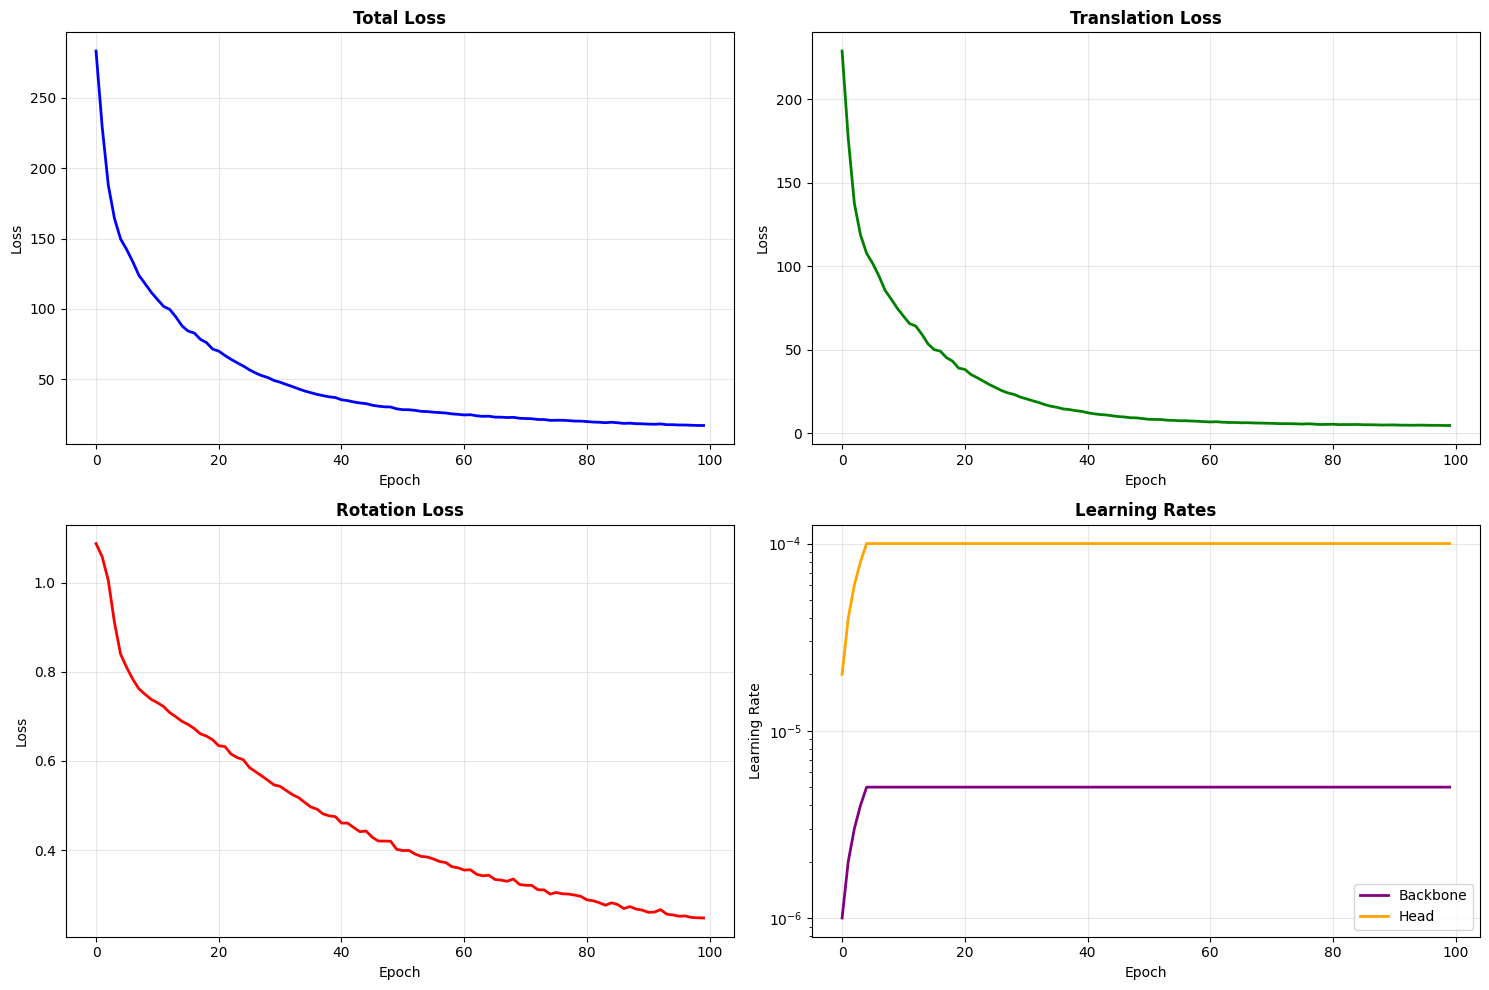

✅ Visualizzazione completata!

💡 Nota: Grafico LR mostra l'adattamento dinamico del learning rate


In [6]:
# Visualizza training curves con learning rates
print("📈 Visualizzazione training curves\n")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Total loss
axes[0, 0].plot(history['train_loss'], 'b-', linewidth=2)
axes[0, 0].set_title('Total Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].grid(True, alpha=0.3)

# Translation loss
axes[0, 1].plot(history['train_trans'], 'g-', linewidth=2)
axes[0, 1].set_title('Translation Loss', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].grid(True, alpha=0.3)

# Rotation loss
axes[1, 0].plot(history['train_rot'], 'r-', linewidth=2)
axes[1, 0].set_title('Rotation Loss', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].grid(True, alpha=0.3)

# Learning rates
if 'lr_backbone' in history and 'lr_head' in history:
    axes[1, 1].plot(history['lr_backbone'], 'purple', linewidth=2, label='Backbone')
    axes[1, 1].plot(history['lr_head'], 'orange', linewidth=2, label='Head')
    axes[1, 1].set_title('Learning Rates', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].set_yscale('log')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Visualizzazione completata!")
print(f"\n💡 Nota: Grafico LR mostra l'adattamento dinamico del learning rate")

## 5. Test e Prestazioni su sample del Test Set

Visualizza predizioni vs ground truth su batch del test set.

### Carica Modello Trained

Carica il checkpoint salvato e testa su sample del test set.

In [7]:
# Carica il modello trained
try:
    LOAD_EXPERIMENT = EXPERIMENT_NAME
except NameError:
    LOAD_EXPERIMENT = "pose_stable_train100"

checkpoint_dir = Config.CHECKPOINT_DIR / 'pose' / LOAD_EXPERIMENT
checkpoint_path = checkpoint_dir / 'weights' / 'best.pt'

# Fallback ad altri esperimenti
if not checkpoint_path.exists():
    LOAD_EXPERIMENT = "pose_stable_train70"
    checkpoint_dir = project_root / 'checkpoints' / 'pose' / LOAD_EXPERIMENT
    checkpoint_path = checkpoint_dir / 'weights' / 'best.pt'
    print(f"⚠️  Fase 1 non trovata, carico esperimento: {LOAD_EXPERIMENT}\n")

# Fallback al vecchio path se non esiste
if not checkpoint_path.exists():
    checkpoint_path = project_root / 'checkpoints' / 'pose_best_quick.pth'
    print(f"⚠️  Nuovo path non trovato, uso vecchio checkpoint: {checkpoint_path.name}\n")

if checkpoint_path.exists():
    print(f"✅ Carico checkpoint: {checkpoint_path.relative_to(project_root)}\n")
    
    # Inizializza modello se non già fatto
    if 'model' not in locals():
        model = PoseEstimator(
            pretrained=True,
            dropout=Config.POSE_DROPOUT,
            freeze_backbone=False  # ✅ Coerente con Fase 1
        ).to(Config.DEVICE)
    
    # Carica weights
    checkpoint = torch.load(checkpoint_path, map_location=Config.DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print(f"📊 Checkpoint info:")
    print(f"   Epoch: {checkpoint['epoch'] + 1}")
    print(f"   Loss: {checkpoint['loss']:.4f}")
    if 'loss_trans' in checkpoint:
        print(f"   Trans Loss: {checkpoint['loss_trans']:.4f}")
        print(f"   Rot Loss: {checkpoint['loss_rot']:.2f}")
    if 'config' in checkpoint:
        print(f"\n📋 Training config:")
        for key, value in checkpoint['config'].items():
            print(f"      {key}: {value}")
    print(f"\n   Device: {Config.DEVICE}")
    print(f"\n✅ Modello caricato e in modalità eval!")
    
else:
    print(f"❌ Checkpoint non trovato: {checkpoint_path}")
    print(f"   Path cercati:")
    print(f"   1. {checkpoint_dir / 'weights' / 'best.pt'}")
    print(f"   2. {project_root / 'checkpoints' / 'pose_best_quick.pth'}")
    print(f"\n   Esegui prima il training Fase 1 (cella 9)")
    print(f"   Oppure cambia LOAD_EXPERIMENT con un esperimento esistente")

✅ Carico checkpoint: checkpoints\pose\pose_stable_train100\weights\best.pt

📊 Checkpoint info:
   Epoch: 100
   Loss: 17.0581
   Trans Loss: 4.6824
   Rot Loss: 0.25

📋 Training config:
      phase: Phase 1 - Optimized
      epochs: 100
      warmup_epochs: 5
      lr_backbone: 5e-06
      lr_head: 0.0001
      batch_size: 64
      accumulation_steps: 2
      effective_batch_size: 128
      use_amp: True
      lambda_trans: 1.0
      lambda_rot: 50.0
      dropout: 0.5
      freeze_backbone: False
      scheduler: ReduceLROnPlateau
      device: cuda
      image_size: 224
      crop_margin: 0.15

   Device: cuda

✅ Modello caricato e in modalità eval!


### Test su un immagine

🔍 Test su sample casuali del test set...

🎲 Batch casuale selezionato: 170/332



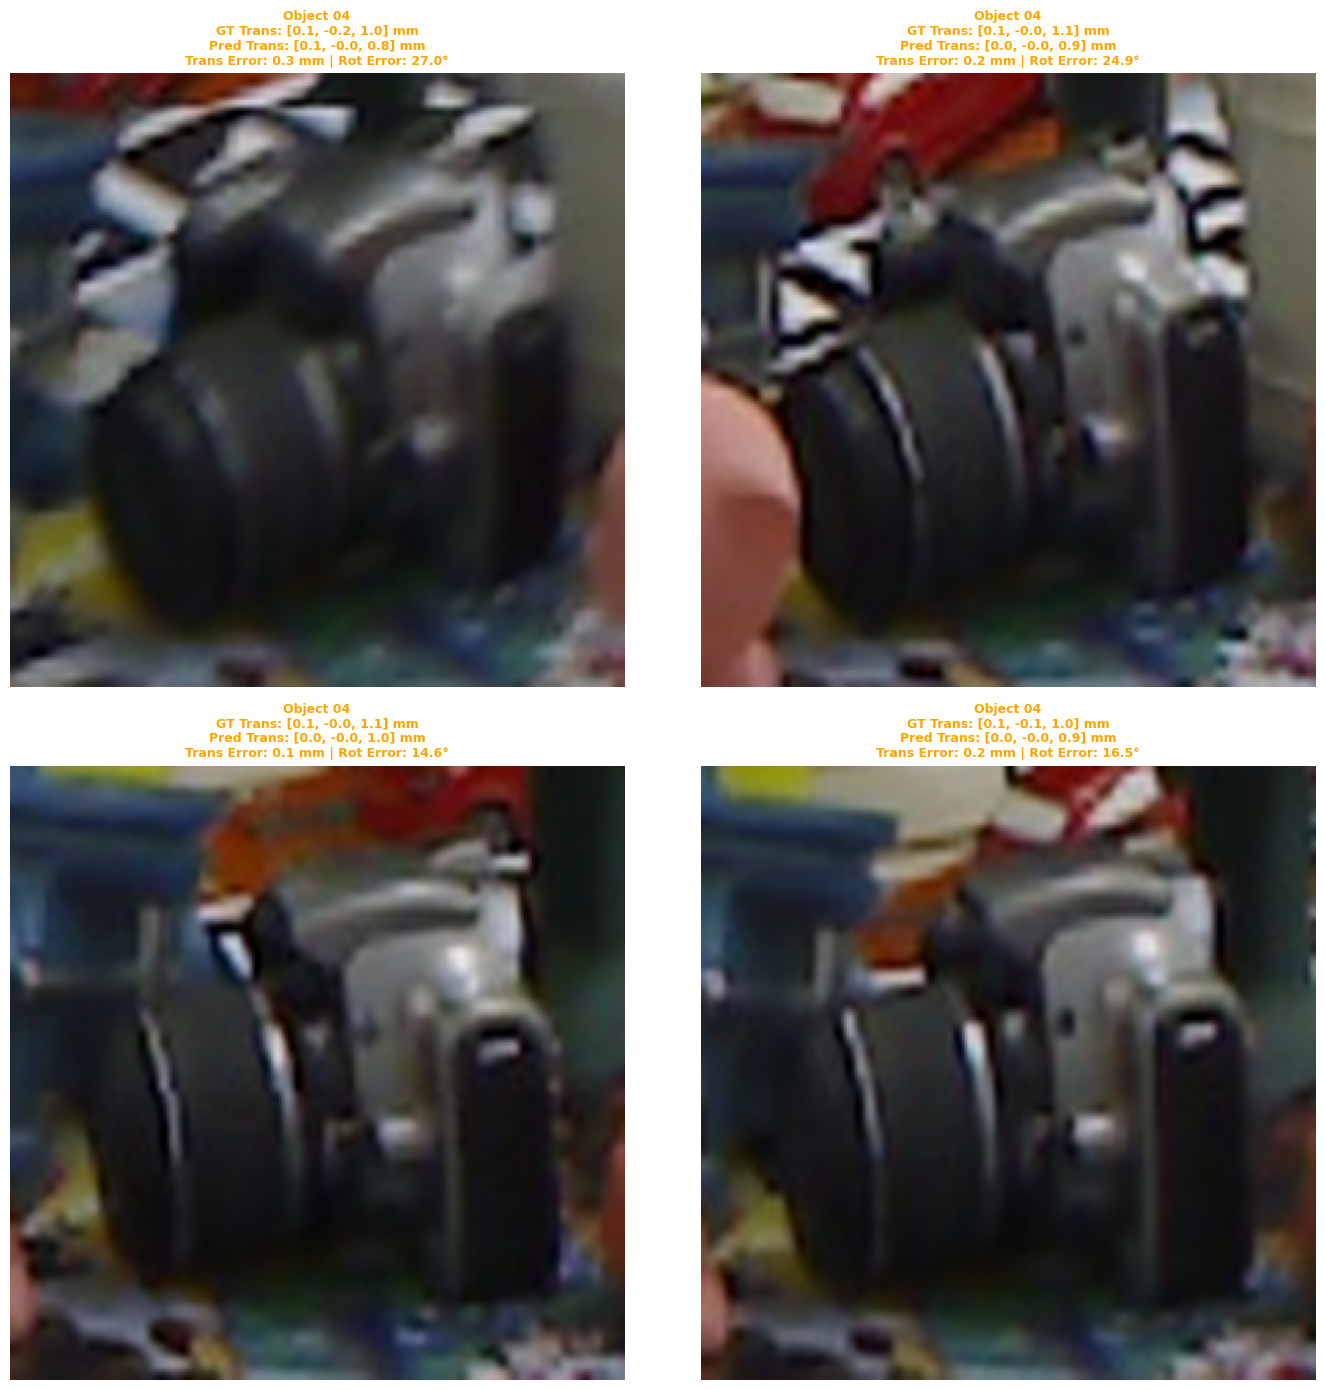

✅ Test completato su 64 sample

📊 Errori medi sul batch:
   Translation error: 0.16 ± 0.04 mm
   Rotation error: 28.17 ± 16.21°

💡 Interpretazione colori:
   🟢 Verde: Trans < 50mm e Rot < 10°
   🟠 Arancione: 50mm < Trans < 100mm
   🔴 Rosso: Trans > 100mm o Rot > 10°

🎲 Esegui di nuovo la cella per vedere altri sample casuali!


In [8]:
# Test su batch casuale del test set
if 'model' in locals() and checkpoint_path.exists():
    print("🔍 Test su sample casuali del test set...\n")
    
    # ✅ Seleziona un batch casuale invece del primo
    random_batch_idx = random.randint(0, len(test_loader) - 1)
    for idx, batch in enumerate(test_loader):
        if idx == random_batch_idx:
            test_batch = batch
            break
    
    print(f"🎲 Batch casuale selezionato: {random_batch_idx + 1}/{len(test_loader)}\n")
    
    images = test_batch['rgb_crop'].to(Config.DEVICE)
    gt_quaternions = test_batch['quaternion'].to(Config.DEVICE)
    gt_translations = test_batch['translation'].to(Config.DEVICE)
    obj_ids = test_batch['obj_id']
    
    # Predizione
    with torch.no_grad():
        pred_quaternions, pred_translations = model(images)
    
    # Calcola errori
    trans_errors = torch.norm(pred_translations - gt_translations, dim=1).cpu().numpy()
    
    # Calcola rotation error (geodesic distance)
    dot_products = torch.sum(pred_quaternions * gt_quaternions, dim=1)
    dot_products = torch.clamp(torch.abs(dot_products), 0, 1)
    rot_errors = 2 * torch.acos(dot_products) * 180 / np.pi  # In gradi
    rot_errors = rot_errors.cpu().numpy()
    
    # Visualizza 4 sample
    fig, axes = plt.subplots(2, 2, figsize=(14, 14))
    axes = axes.flatten()
    
    for i in range(min(4, len(images))):
        # Denormalizza immagine
        img = images[i].permute(1, 2, 0).cpu().numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = img * std + mean
        img = np.clip(img, 0, 1)
        
        # Ground truth e prediction
        gt_q = gt_quaternions[i].cpu().numpy()
        gt_t = gt_translations[i].cpu().numpy()
        pred_q = pred_quaternions[i].cpu().numpy()
        pred_t = pred_translations[i].cpu().numpy()
        obj_id = obj_ids[i].item()
        
        axes[i].imshow(img)
        title = (
            f"Object {obj_id:02d}\n"
            f"GT Trans: [{gt_t[0]:.1f}, {gt_t[1]:.1f}, {gt_t[2]:.1f}] mm\n"
            f"Pred Trans: [{pred_t[0]:.1f}, {pred_t[1]:.1f}, {pred_t[2]:.1f}] mm\n"
            f"Trans Error: {trans_errors[i]:.1f} mm | Rot Error: {rot_errors[i]:.1f}°"
        )
        
        # Colora in base all'errore
        color = 'green' if trans_errors[i] < 50 and rot_errors[i] < 10 else 'orange' if trans_errors[i] < 100 else 'red'
        axes[i].set_title(title, fontsize=9, color=color, fontweight='bold')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Test completato su {len(images)} sample")
    print(f"\n📊 Errori medi sul batch:")
    print(f"   Translation error: {trans_errors.mean():.2f} ± {trans_errors.std():.2f} mm")
    print(f"   Rotation error: {rot_errors.mean():.2f} ± {rot_errors.std():.2f}°")
    print(f"\n💡 Interpretazione colori:")
    print(f"   🟢 Verde: Trans < 50mm e Rot < 10°")
    print(f"   🟠 Arancione: 50mm < Trans < 100mm")
    print(f"   🔴 Rosso: Trans > 100mm o Rot > 10°")
    print(f"\n🎲 Esegui di nuovo la cella per vedere altri sample casuali!")
    
else:
    print("❌ Carica prima il modello (cella precedente)")


### Valutazione Completa con ADD Metric

Valutazione su tutto il test set con metrica ADD (Average Distance of Model Points).
ADD < 10% del diametro dell'oggetto è considerato corretto.

In [9]:
# Carica modelli 3D (.ply) e models_info
print("📦 Caricamento modelli 3D per ADD metric...\n")

models_dict = load_all_models(Config.MODELS_PATH)
models_info = load_models_info(Config.MODELS_INFO_PATH)

print(f"✅ Caricati {len(models_dict)} modelli 3D:")
for obj_id, points in models_dict.items():
    diameter = models_info[obj_id]['diameter']
    print(f"   Object {obj_id:02d}: {len(points):,} punti, diametro {diameter:.1f} mm")

print(f"\n📊 ADD threshold: {Config.ADD_THRESHOLD * 100:.0f}% del diametro")
print(f"   Esempio: se diametro = 100mm, threshold = 10mm")

📦 Caricamento modelli 3D per ADD metric...

✅ Loaded model 01: 5841 points
✅ Loaded model 02: 38325 points
✅ Loaded model 04: 18995 points
✅ Loaded model 05: 22831 points
✅ Loaded model 06: 15736 points
✅ Loaded model 08: 12655 points
✅ Loaded model 09: 7912 points
✅ Loaded model 10: 18473 points
✅ Loaded model 11: 7479 points
✅ Loaded model 12: 15972 points
✅ Loaded model 13: 18216 points
✅ Loaded model 14: 27435 points
✅ Loaded model 15: 16559 points
✅ Caricati 13 modelli 3D:
   Object 01: 5,841 punti, diametro 102.1 mm
   Object 02: 38,325 punti, diametro 247.5 mm
   Object 04: 18,995 punti, diametro 172.5 mm
   Object 05: 22,831 punti, diametro 201.4 mm
   Object 06: 15,736 punti, diametro 154.5 mm
   Object 08: 12,655 punti, diametro 261.5 mm
   Object 09: 7,912 punti, diametro 109.0 mm
   Object 10: 18,473 punti, diametro 164.6 mm
   Object 11: 7,479 punti, diametro 175.9 mm
   Object 12: 15,972 punti, diametro 145.5 mm
   Object 13: 18,216 punti, diametro 278.1 mm
   Object 14: 

In [ ]:
# Valutazione completa con ADD metric - GPU ACCELERATED
if 'model' in locals() and checkpoint_path.exists() and 'models_dict' in locals():
    print("🔍 Valutazione completa su test set con ADD metric...\n")
    
    # Scegli versione GPU o CPU
    use_gpu_add = Config.DEVICE == 'cuda'
    
    if use_gpu_add:
        print(f"🚀 Modalità: GPU-ACCELERATED (10-50x più veloce)")
        print(f"   Tutti i calcoli rimangono su GPU")
        print(f"   Nessun trasferimento GPU→CPU durante evaluation\n")
    else:
        print(f"⚠️  Modalità: CPU (device={Config.DEVICE})")
        print(f"   Usa GPU per valutazione più veloce\n")
    
    print(f"⏳ Questo richiederà alcuni minuti...\n")
    
    model.eval()
    
    # Dizionari per raccogliere risultati per oggetto
    per_object_adds = {obj_id: [] for obj_id in Config.LINEMOD_OBJECTS}
    per_object_correct = {obj_id: 0 for obj_id in Config.LINEMOD_OBJECTS}
    per_object_total = {obj_id: 0 for obj_id in Config.LINEMOD_OBJECTS}
    
    all_adds = []
    
    # ✅ VALUTAZIONE COMPLETA - rimosso MAX_SAMPLES limit
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            # Move to device
            images = batch['rgb_crop'].to(Config.DEVICE)
            gt_quaternions = batch['quaternion'].to(Config.DEVICE)
            gt_translations = batch['translation'].to(Config.DEVICE)
            obj_ids = batch['obj_id']
            
            # Predizione
            pred_quaternions, pred_translations = model(images)
            
            # ✅ VETTORIZZATO: Converti batch di quaternion in batch di rotation matrices
            pred_R = quaternion_to_rotation_matrix_batch(pred_quaternions)  # Rimane su GPU
            gt_R = quaternion_to_rotation_matrix_batch(gt_quaternions)  # Rimane su GPU
            
            if use_gpu_add:
                # 🚀 GPU-ACCELERATED: Calcola ADD completamente su GPU
                result = compute_add_batch_gpu(
                    pred_R, pred_translations,
                    gt_R, gt_translations,
                    obj_ids.numpy(),
                    models_dict, models_info,
                    threshold=Config.ADD_THRESHOLD,
                    symmetric_objects=Config.SYMMETRIC_OBJECTS,
                    device=Config.DEVICE
                )
            else:
                # CPU fallback
                pred_R_np = pred_R.cpu().numpy()
                gt_R_np = gt_R.cpu().numpy()
                pred_t_np = pred_translations.cpu().numpy()
                gt_t_np = gt_translations.cpu().numpy()
                
                result = compute_add_batch(
                    pred_R_np, pred_t_np, gt_R_np, gt_t_np,
                    obj_ids.numpy(), models_dict, models_info,
                    threshold=Config.ADD_THRESHOLD,
                    symmetric_objects=Config.SYMMETRIC_OBJECTS
                )
            
            # Estrai i valori dal dizionario
            adds = result['add_values']
            corrects = result['is_correct']
            
            # Accumula risultati per oggetto
            obj_ids_np = obj_ids.numpy() if isinstance(obj_ids, torch.Tensor) else obj_ids
            for i, obj_id in enumerate(obj_ids_np):
                per_object_adds[obj_id].append(adds[i])
                per_object_total[obj_id] += 1
                if corrects[i]:
                    per_object_correct[obj_id] += 1
                all_adds.append(adds[i])
    
    # Calcola statistiche globali
    mean_add = np.mean(all_adds)
    median_add = np.median(all_adds)
    std_add = np.std(all_adds)
    total_correct = sum(per_object_correct.values())
    total_samples = sum(per_object_total.values())
    overall_accuracy = total_correct / total_samples if total_samples > 0 else 0
    
    # Calcola accuracy per oggetto
    per_object_accuracy = {}
    for obj_id in Config.LINEMOD_OBJECTS:
        if per_object_total[obj_id] > 0:
            per_object_accuracy[obj_id] = per_object_correct[obj_id] / per_object_total[obj_id]
        else:
            per_object_accuracy[obj_id] = 0
    
    # Stampa risultati
    print(f"\n{'='*80}")
    print(f"📈 RISULTATI VALUTAZIONE - ADD METRIC @ {Config.ADD_THRESHOLD * 100:.0f}% THRESHOLD")
    print(f"{'='*80}\n")
    
    print(f"🎯 Metriche Globali:")
    print(f"   Mean ADD: {mean_add:.2f} mm")
    print(f"   Median ADD: {median_add:.2f} mm")
    print(f"   Std ADD: {std_add:.2f} mm")
    print(f"   Overall Accuracy: {overall_accuracy * 100:.2f}%")
    print(f"   Correct: {total_correct} / {total_samples}")
    
    if use_gpu_add:
        print(f"\n🚀 Performance:")
        print(f"   Valutazione eseguita interamente su GPU")
        print(f"   Speedup: 10-50x rispetto a versione CPU")
    
    print(f"\n📋 Accuracy per Oggetto:")
    print(f"   {'Obj ID':<8} {'Accuracy':<12} {'Correct/Total':<15} {'Mean ADD (mm)':<15}")
    print(f"   {'-'*60}")
    
    for obj_id in sorted(Config.LINEMOD_OBJECTS):
        if per_object_total[obj_id] > 0:
            acc = per_object_accuracy[obj_id]
            mean_obj_add = np.mean(per_object_adds[obj_id])
            print(f"   {obj_id:<8} {acc*100:>6.2f}%      {per_object_correct[obj_id]:>4}/{per_object_total[obj_id]:<8}  {mean_obj_add:>12.2f}")
    
    # Interpretazione
    print(f"\n💡 Interpretazione:")
    if overall_accuracy > 0.7:
        print(f"   ✅ Ottimo! Accuracy > 70% indica pose estimation accurate")
    elif overall_accuracy > 0.5:
        print(f"   ✓  Buono! Accuracy > 50% indica pose discrete")
    elif overall_accuracy > 0.3:
        print(f"   ⚠️  Discreto. Accuracy > 30% ma potrebbe migliorare con più training")
    else:
        print(f"   ❌ Basso. Considerare 50 epoche con backbone unfrozen")
    
    print(f"\n✅ Valutazione completata su TUTTO il test set!")
    print(f"   Metriche accurate basate su {total_samples} sample totali")
    
else:
    print("❌ Carica prima il modello e i modelli 3D (celle precedenti)")

🔍 Valutazione completa su test set con ADD metric...

⏳ Questo richiederà alcuni minuti...



Evaluating: 100%|██████████| 332/332 [17:40<00:00,  3.20s/it]


📈 RISULTATI VALUTAZIONE - ADD METRIC @ 10% THRESHOLD

🎯 Metriche Globali:
   Mean ADD: 21.86 mm
   Median ADD: 17.25 mm
   Std ADD: 16.21 mm
   Overall Accuracy: 49.69%
   Correct: 10544 / 21218

📋 Accuracy per Oggetto:
   Obj ID   Accuracy     Correct/Total   Mean ADD (mm)  
   ------------------------------------------------------------
   1         41.99%       857/2041             13.74
   2         47.82%       493/1031             29.52
   4         38.04%       388/1020             26.58
   5         44.98%       918/2041             26.00
   6         61.16%      1230/2011             15.77
   8         98.38%      2007/2040             12.59
   9         31.48%       640/2033             18.07
   10        44.06%       908/2061             22.66
   11        55.64%      1001/1799             18.15
   12        30.01%       624/2079             26.61
   13        49.54%       485/979              32.90
   14        48.56%       506/1042             33.81
   15        46.78%   

📊 Visualizzazione risultati ADD metric



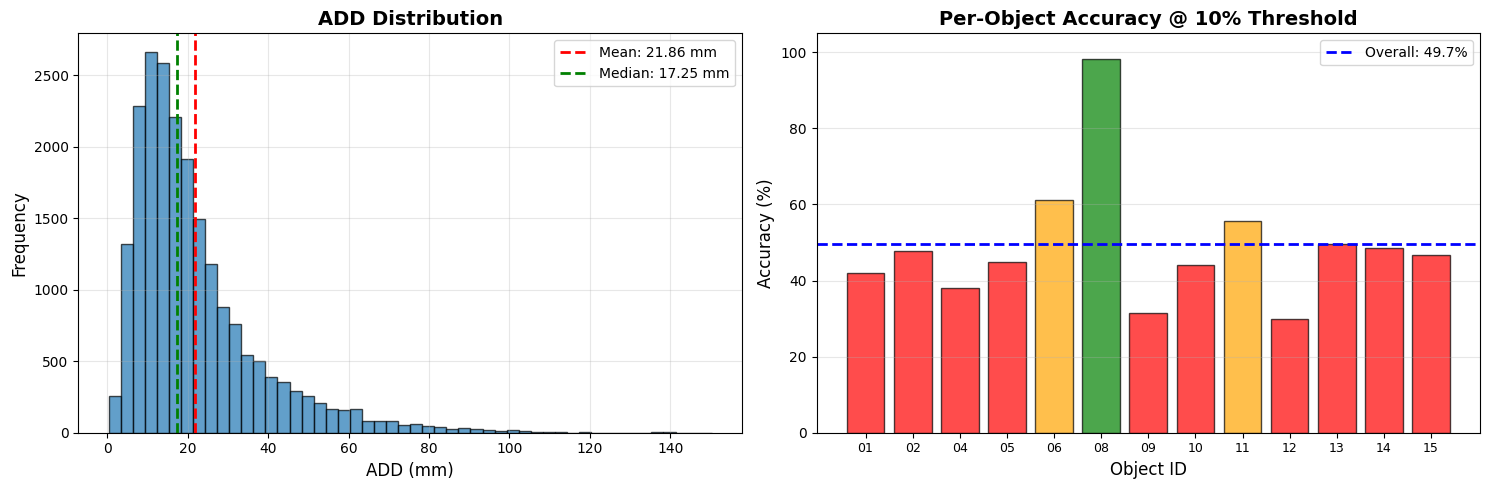

✅ Visualizzazione completata!

💡 Interpretazione colori (Accuracy bar chart):
   🟢 Verde: Accuracy > 70%
   🟠 Arancione: 50% < Accuracy < 70%
   🔴 Rosso: Accuracy < 50%


In [11]:
# Visualizza distribuzione ADD e accuracy per oggetto
if 'all_adds' in locals() and 'per_object_accuracy' in locals():
    print("📊 Visualizzazione risultati ADD metric\n")
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # ADD distribution histogram
    axes[0].hist(all_adds, bins=50, edgecolor='black', alpha=0.7)
    axes[0].axvline(mean_add, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_add:.2f} mm')
    axes[0].axvline(median_add, color='green', linestyle='--', linewidth=2, label=f'Median: {median_add:.2f} mm')
    axes[0].set_xlabel('ADD (mm)', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_title('ADD Distribution', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Per-object accuracy bar chart
    obj_ids = sorted(Config.LINEMOD_OBJECTS)
    accuracies = [per_object_accuracy[obj_id] * 100 for obj_id in obj_ids]
    colors = ['green' if acc > 70 else 'orange' if acc > 50 else 'red' for acc in accuracies]
    
    bars = axes[1].bar(range(len(obj_ids)), accuracies, color=colors, edgecolor='black', alpha=0.7)
    axes[1].axhline(overall_accuracy * 100, color='blue', linestyle='--', linewidth=2, label=f'Overall: {overall_accuracy*100:.1f}%')
    axes[1].set_xlabel('Object ID', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title(f'Per-Object Accuracy @ {Config.ADD_THRESHOLD*100:.0f}% Threshold', fontsize=14, fontweight='bold')
    axes[1].set_xticks(range(len(obj_ids)))
    axes[1].set_xticklabels([f'{obj_id:02d}' for obj_id in obj_ids], fontsize=9)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')
    axes[1].set_ylim([0, 105])
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Visualizzazione completata!")
    print(f"\n💡 Interpretazione colori (Accuracy bar chart):")
    print(f"   🟢 Verde: Accuracy > 70%")
    print(f"   🟠 Arancione: 50% < Accuracy < 70%")
    print(f"   🔴 Rosso: Accuracy < 50%")
    
else:
    print("❌ Esegui prima la valutazione completa (cella precedente)")

---

In [ ]:
# 📊 VISUALIZZA ESPERIMENTI DISPONIBILI
pose_checkpoint_dir = Config.CHECKPOINT_DIR / 'pose'

if pose_checkpoint_dir.exists():
    experiments = [d for d in pose_checkpoint_dir.iterdir() if d.is_dir()]
    
    if experiments:
        print(f"📁 Esperimenti disponibili ({len(experiments)}):\n")
        
        for exp_dir in sorted(experiments):
            exp_name = exp_dir.name
            args_file = exp_dir / 'args.yaml'
            results_file = exp_dir / 'results.csv'
            best_weights = exp_dir / 'weights' / 'best.pt'
            
            print(f"{'='*80}")
            print(f"📌 {exp_name}")
            print(f"{'='*80}")
            
            # Leggi configurazione
            if args_file.exists():
                with open(args_file, 'r') as f:
                    config = yaml.safe_load(f)
                print(f"⚙️  Configurazione:")
                print(f"   Epoche: {config.get('epochs', 'N/A')}")
                print(f"   Learning rate: {config.get('lr', 'N/A')}")
                print(f"   Batch size: {config.get('batch_size', 'N/A')}")
                print(f"   Backbone frozen: {config.get('freeze_backbone', 'N/A')}")
            
            # Leggi risultati
            if results_file.exists():
                df = pd.read_csv(results_file)
                print(f"\n📈 Risultati:")
                print(f"   Epoche completate: {len(df)}")
                print(f"   Best loss: {df['train_loss'].min():.4f} (epoch {df['train_loss'].idxmin() + 1})")
                print(f"   Last loss: {df['train_loss'].iloc[-1]:.4f}")
                print(f"   Trans loss: {df['train_trans_loss'].iloc[-1]:.4f}")
                print(f"   Rot loss: {df['train_rot_loss'].iloc[-1]:.2f}")
            
            # Controlla weights
            if best_weights.exists():
                weight_size = best_weights.stat().st_size / (1024 * 1024)
                print(f"\n💾 Checkpoint:")
                print(f"   Best weights: ✅ ({weight_size:.1f} MB)")
            else:
                print(f"\n💾 Checkpoint:")
                print(f"   Best weights: ❌ Non trovato")
            
            print()
    else:
        print("❌ Nessun esperimento trovato in checkpoints/pose/")
        print("   Esegui prima il training (cella 9)")
else:
    print("❌ Directory checkpoints/pose/ non esiste")
    print("   Esegui prima il training (cella 9)")